# **Identification**

* **Name:** Joaquim Daniel Rios da Cunha
* **Student Number:** 201806651

* **Name:** Pedro Miguel Pinto Silva
* **Student Number:** 201806526

In [114]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display since cv2.imshow crashes the Colab
import glob
from numpy.matrixlib import mat
import matplotlib.pyplot as plt


 ## Alinea a - Camera intrinsic parameters and lens distortion

In [115]:
# Chess Info
X = 8
Y= 5
innerX = X-1
innerY = Y-1
dist = 0.001

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, dist)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((innerX*innerY,3), np.float32)
objp[:,:2] = np.mgrid[0:innerX,0:innerY].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob("./IntrinsicCalibration/*.png")

print("# of images for calibration " + str(len(images)))
display_first = False
img = cv.imread(images[0])
gray = np.array(img.shape,np.uint8)
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (innerX,innerY), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (innerX,innerY), corners2, ret)
    if display_first == True:
        cv2_imshow()
        display_first = False

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Retification value: ",ret)
print(" ")
print("Intrinsic Matrix K:")
print(mtx)
print(" ")
print("Distorcion Coefs (k1 k2 p1 p2 k3):")
print(dist)

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)))

# of images for calibration 36
Retification value:  0.4916772579692308
 
Intrinsic Matrix K:
[[1.32164961e+03 0.00000000e+00 9.88299668e+02]
 [0.00000000e+00 1.32444624e+03 6.42259078e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
 
Distorcion Coefs (k1 k2 p1 p2 k3):
[[-3.44269790e-01  9.00566070e-02  9.45585473e-05 -3.97940160e-04
  -3.15658830e-03]]
total error: 0.08655252216985401



## Alinea b - Relation between mm and px


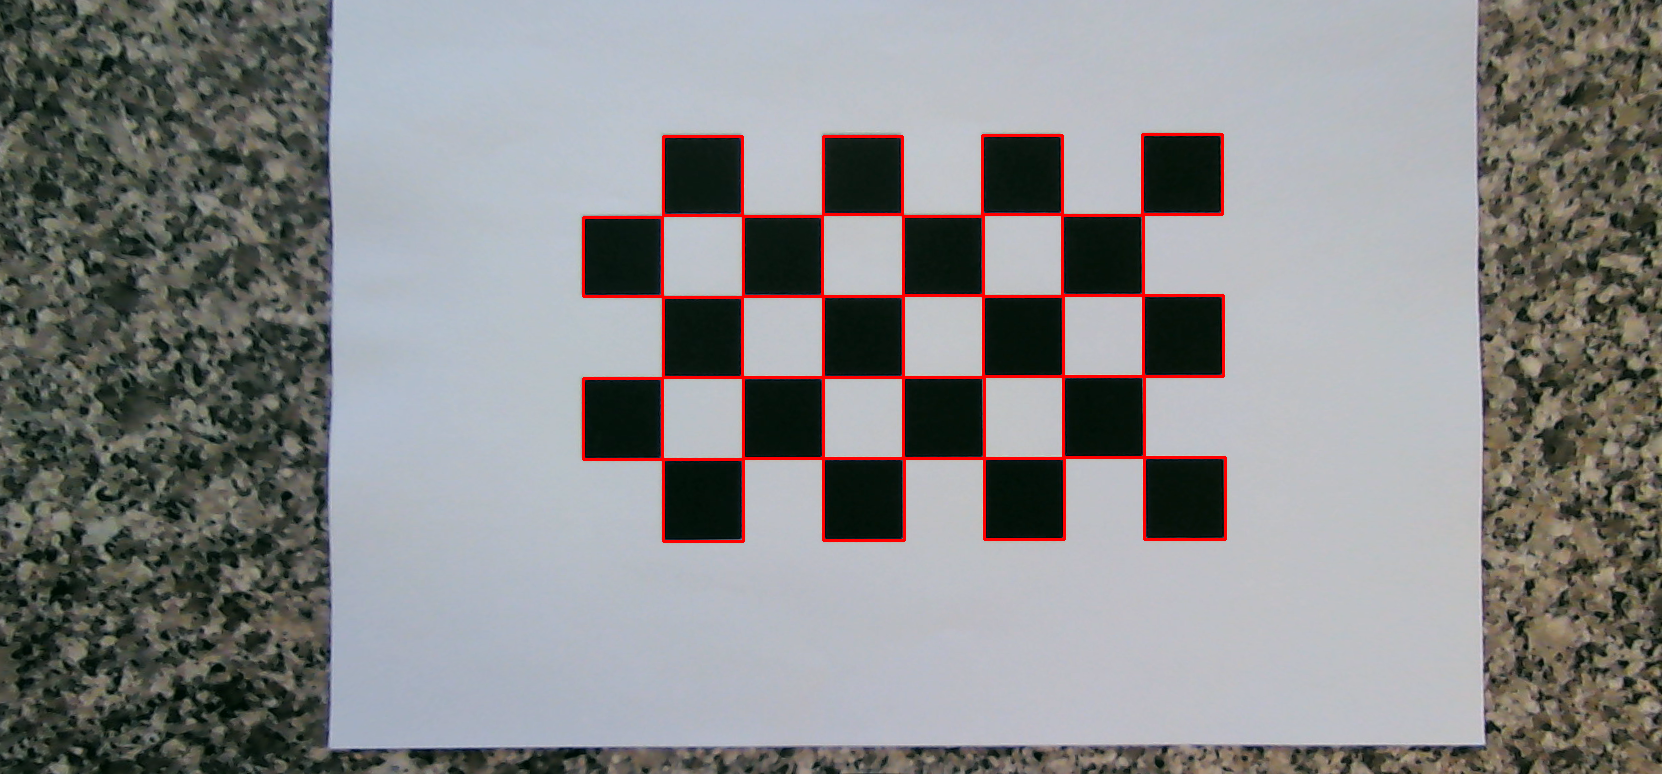

Contours size after filter: 20
Mean side in pixels:  80.15
Ratio 3.816666666666667 px/mm


In [116]:
## Load the extrinsic image
extrinsic = cv.imread("./WhiteBackground/extrinsic.png")

h, w = extrinsic.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# undistort
undist = cv.undistort(extrinsic, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
undist = undist[y:y+h, x:x+w]
#cv2_imshow(undist)

img_gray = cv.cvtColor(undist, cv.COLOR_BGR2GRAY)

# Blur the image for better edge detection
#img_blur = cv.GaussianBlur(img_gray, (5,5), 0)
# O filtro median foi utilizado em detrimento do GaussianBlur pois preserva as edges
img_blur = cv.medianBlur(src=img_gray, ksize=5)
ret,th = cv.threshold(img_blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# canny Edge Detection
lowrate= 1
img_canny = cv.Canny(img_blur, ret*lowrate, ret)

contours, hierarchy = cv.findContours(img_canny,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

res = undist.copy()
cnt = 0 
sum_side = 0
# Consider only contours with area higher than 1000
for c in range(len(contours)):
  if (cv.contourArea(contours[c],True) < 1000):
    continue

  # For rectangles
  x,y,w,h = cv.boundingRect(contours[c])
  sum_side = sum_side + w + h
  cv.rectangle(res,(x,y),(x+w,y+h),(0,0,255),2)
  cnt = cnt + 1

cv2_imshow(res)

square_size = 21 #mm
mean_side = sum_side / (cnt*2)
ratio_px_mm = mean_side/square_size
print("Contours size after filter:", cnt)
print("Mean side in pixels: ", mean_side)
print("Ratio " + str(ratio_px_mm) + " px/mm")


## Alínea c - Color Distribution with white background


### Extract the ROI

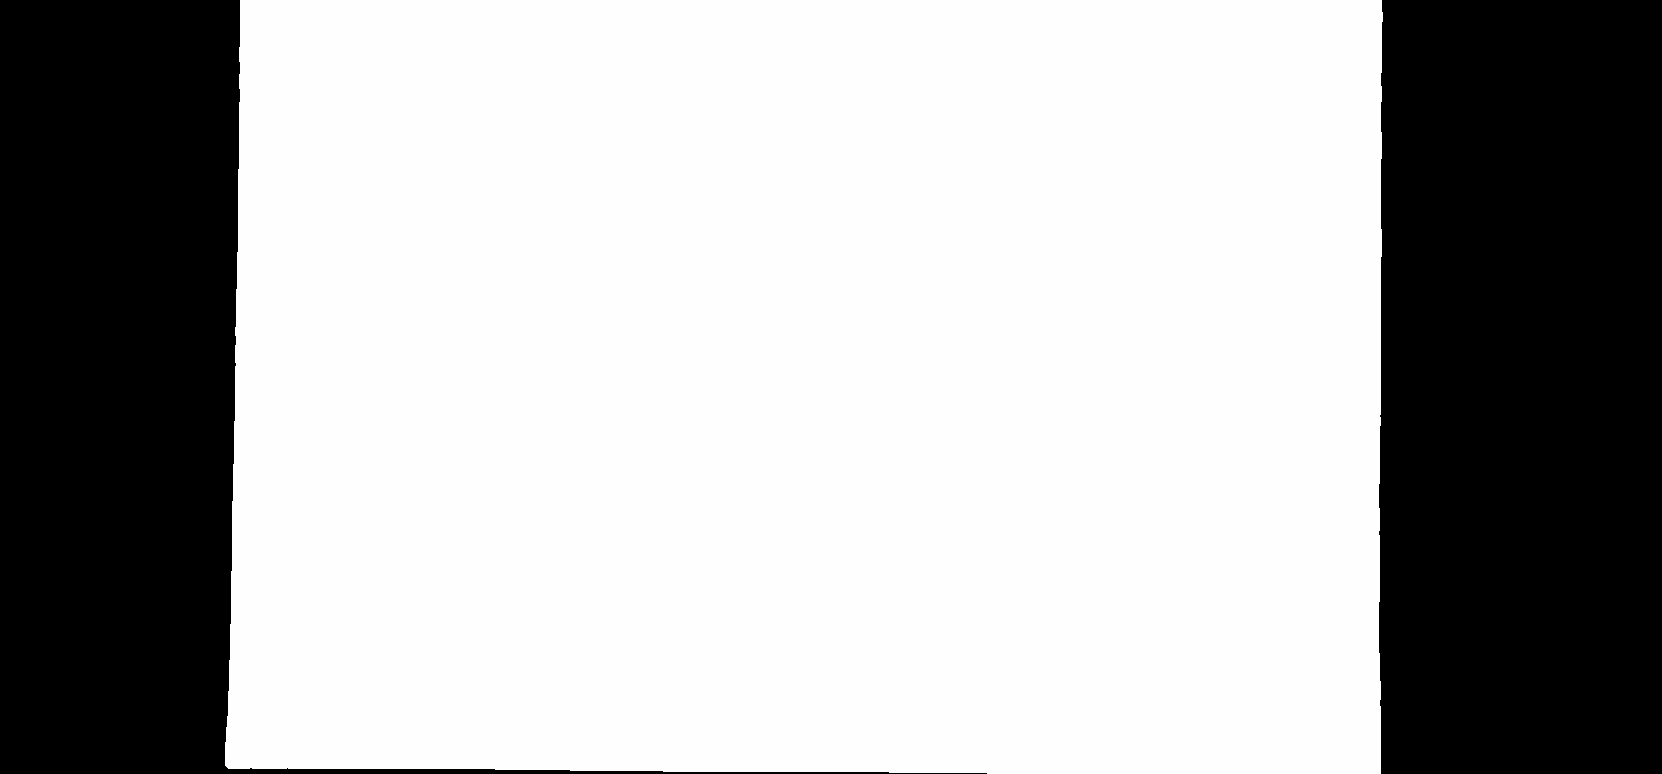

In [117]:
## Load the extrinsic image
blank = cv.imread("./WhiteBackground/calib_img 0.png")
#cv2_imshow(blank)

h, w = blank.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# undistort
dst = cv.undistort(blank, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
#cv2_imshow(dst)

gray = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

# getting mask with connectComponents
ret, labels = cv.connectedComponents(binary)

mask_bkg = np.array(labels, dtype=np.uint8)
mask_bkg[labels == 0] = 0

mask_white = np.array(labels, dtype=np.uint8)
mask_white[labels == 1] = 255 
mask = cv.bitwise_xor(mask_bkg,mask_white)

kernel = np.ones((5, 5), 'uint8')
eroded = cv.erode(mask, kernel, iterations=2)
opened = cv.dilate(eroded, kernel, iterations=2)

cv2_imshow(opened)    

### Peanuts identification and Color Distribution

Looking for blue peanuts in the image 1
   Peanuts found!
   Areas in px: [3351.0, 2848.0, 3508.5, 3804.0, 3902.5]
   Areas in mm [230.04 195.51 240.85 261.14 267.9 ]
Looking for yellow peanuts in the image 1
   Peanuts found!
   Areas in px: [4463.0, 4153.5, 3179.5, 3048.0, 4223.0]
   Areas in mm [306.38 285.13 218.27 209.24 289.9 ]
Looking for green peanuts in the image 1
   Color green is missing!
Looking for red peanuts in the image 1
   Color red is missing!


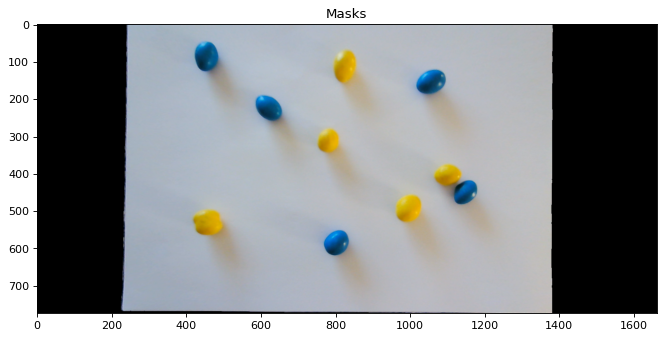

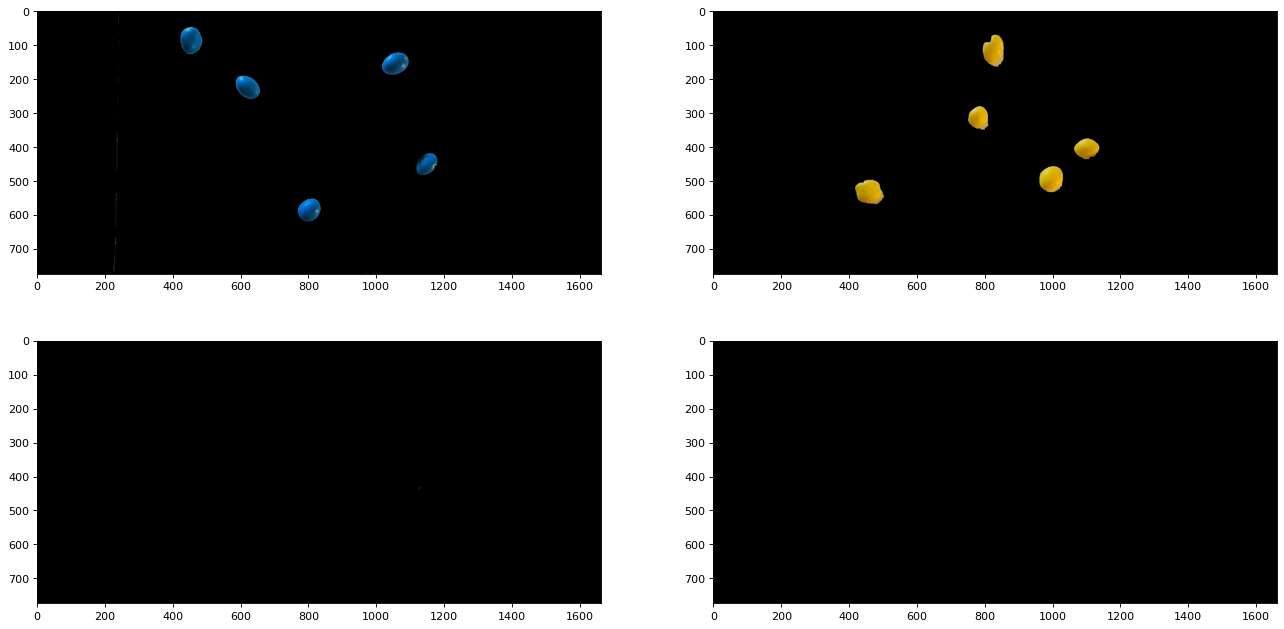

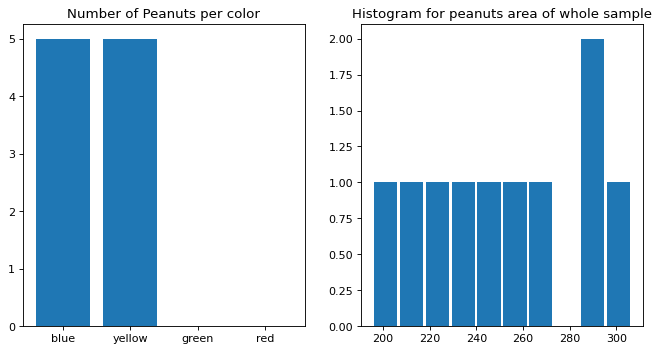

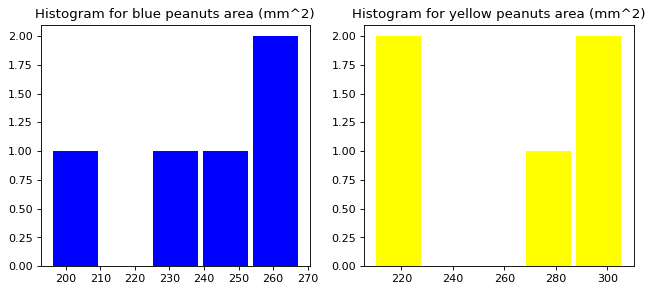


Looking for blue peanuts in the image 2
   Peanuts found!
   Areas in px: [3385.5, 2879.5, 3545.5, 3867.5, 3965.5]
   Areas in mm [232.41 197.67 243.39 265.5  272.23]
Looking for yellow peanuts in the image 2
   Peanuts found!
   Areas in px: [4348.0, 4192.5, 3165.5, 3037.0, 4123.5]
   Areas in mm [298.48 287.81 217.31 208.49 283.07]
Looking for green peanuts in the image 2
   Color green is missing!
Looking for red peanuts in the image 2
   Peanuts found!
   Areas in px: [2411.0, 3758.0, 2253.0, 3143.5, 3050.0]
   Areas in mm [165.51 257.98 154.67 215.8  209.38]


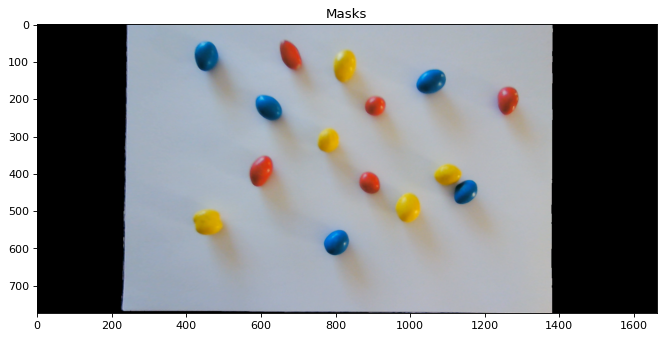

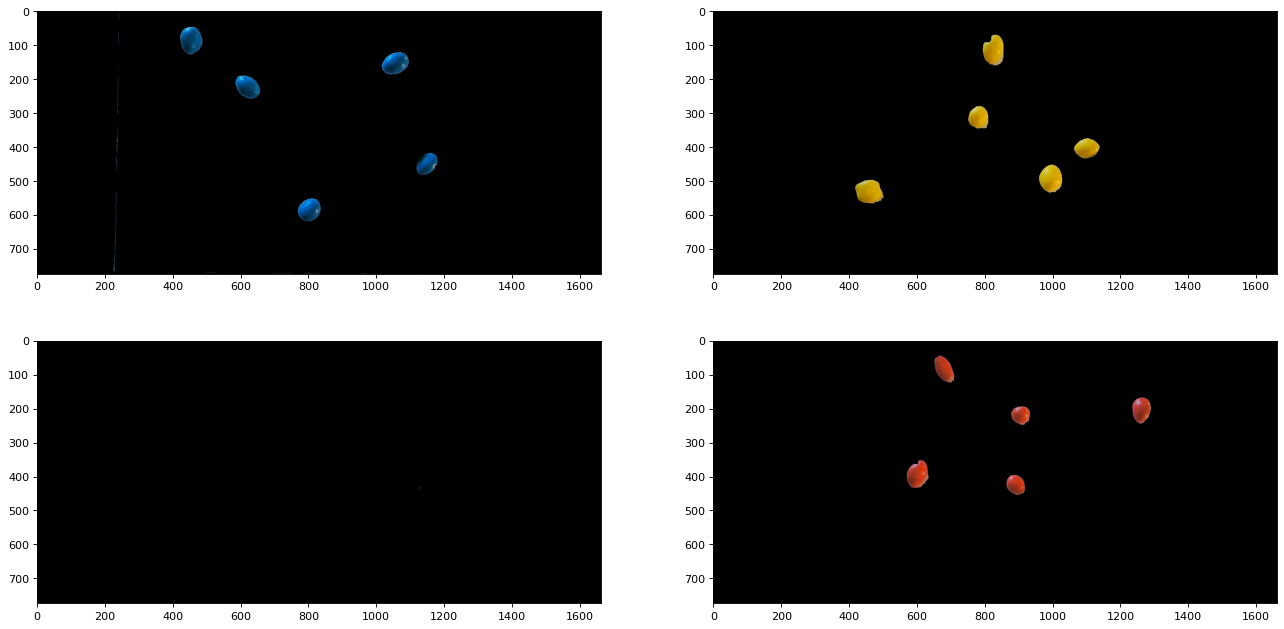

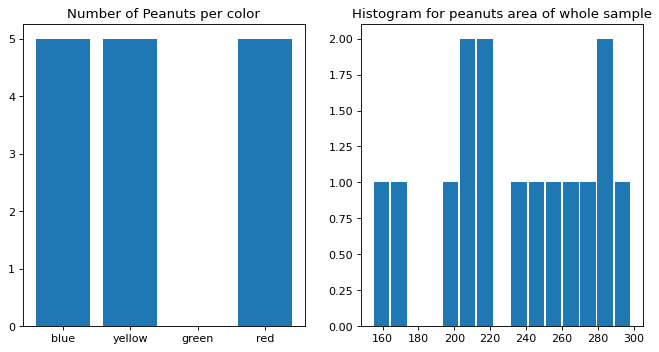

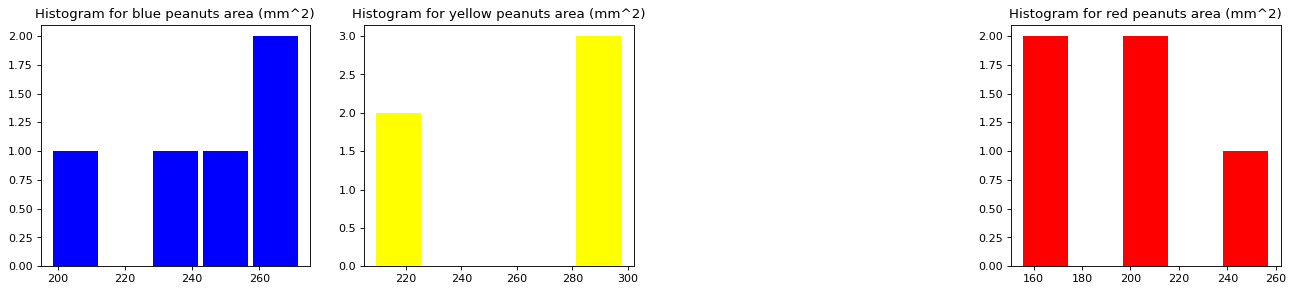


Looking for blue peanuts in the image 3
   Peanuts found!
   Areas in px: [3426.5, 2938.5, 3647.0, 3945.5, 4089.0]
   Areas in mm [235.22 201.72 250.36 270.85 280.7 ]
Looking for yellow peanuts in the image 3
   Peanuts found!
   Areas in px: [4217.0, 4149.0, 3129.0, 2905.0, 3931.5]
   Areas in mm [289.49 284.82 214.8  199.42 269.89]
Looking for green peanuts in the image 3
   Peanuts found!
   Areas in px: [2991.0, 3078.5, 2128.0]
   Areas in mm [205.33 211.33 146.08]
Looking for red peanuts in the image 3
   Peanuts found!
   Areas in px: [2378.0, 3615.0, 2242.0, 3102.0, 2978.0]
   Areas in mm [163.25 248.16 153.91 212.95 204.44]


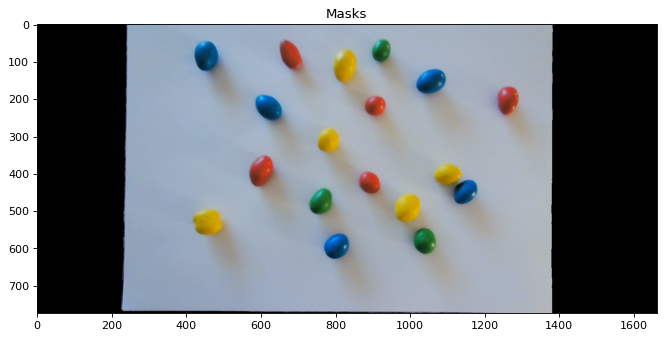

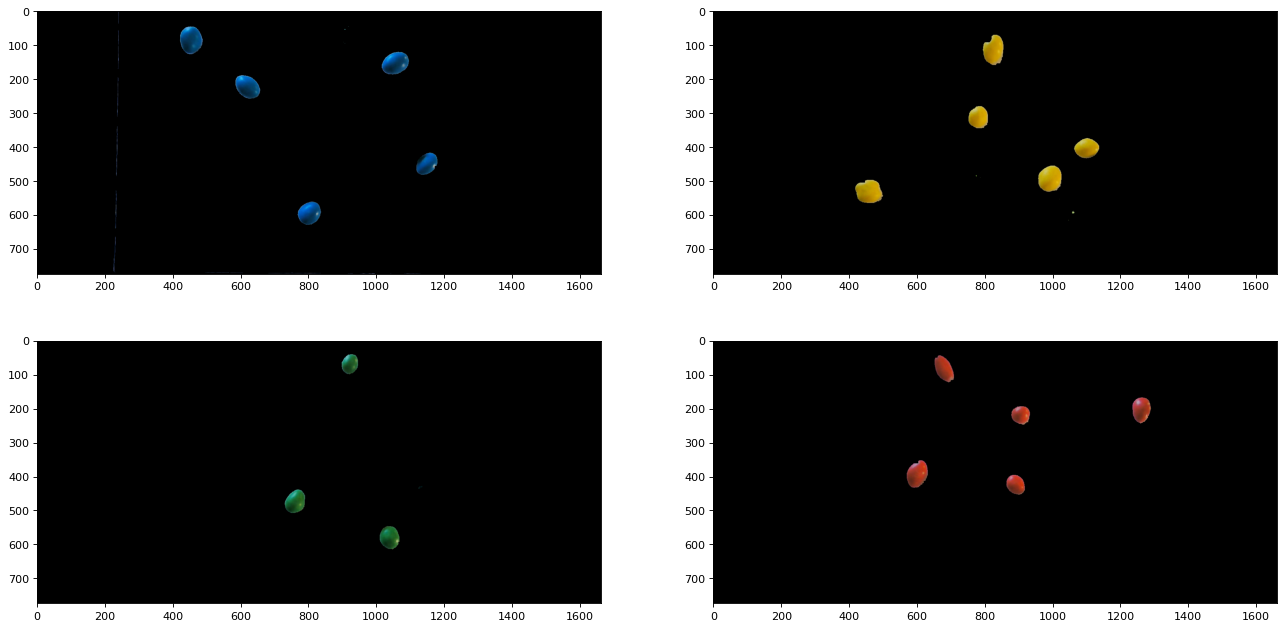

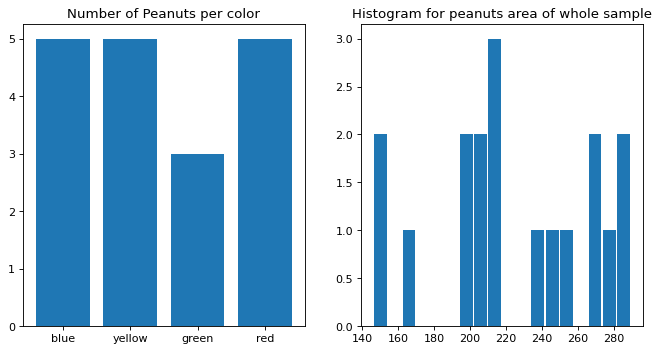

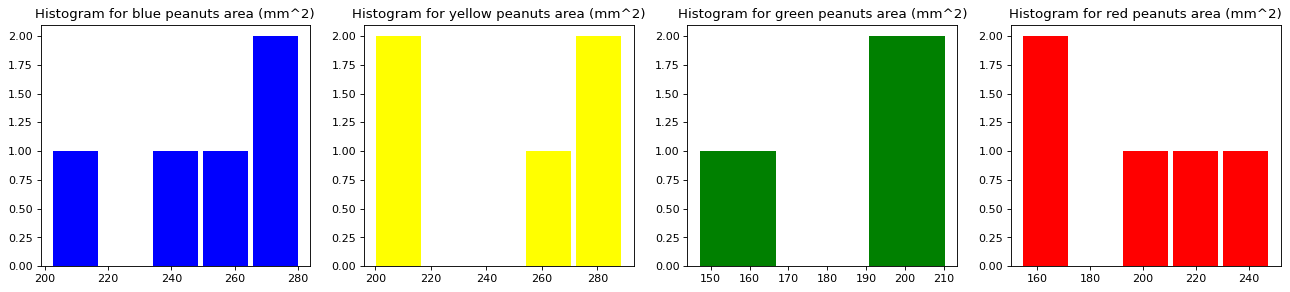

In [118]:
colors =  ['blue','yellow','green','red']

lower = np.array([[90,120,20],[20,100,15],[35,100,20],[160,100,20],[0,100,20]])
upper = np.array([[125,255,255],[45,255,255],[92,255,255],[179,255,255],[10,255,255]])
areas = []
areas_in_px = []
areas_in_mm = []

ratio_mm_px = 1 / ratio_px_mm


for i in range(1,4):
  ## Load the image
  title = "./WhiteBackground/calib_img " + str(i) +".png" 
  img_mm = cv.imread(title)
  #cv2_imshow(img_mm)

  h, w = img_mm.shape[:2]
  newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(img_mm, mtx, dist, None, newcameramtx)
  # crop the image
  x, y, w, h = roi
  dst = dst[y:y+h, x:x+w]
  #cv2_imshow(dst)

  filtered = cv.bitwise_and(dst,dst,mask=opened)
  #cv2_imshow(filtered)

  "  ************ RGB Color Space ************* "
  img_rgb = cv.cvtColor(filtered, cv.COLOR_BGR2RGB)

  sum_area = np.array([0,0,0,0])
  sum_peanuts = np.array([0,0,0,0])

  masks_img = []
  masks_img.append(filtered)

  areas = []

  for idx,color in enumerate(colors):

    areas_in_px = []
    areas_in_mm = []

    print("Looking for " + color + " peanuts in the image " + str(i))
    frame_HSV = cv.cvtColor(img_rgb, cv.COLOR_RGB2HSV)
    "  ************ Segmentation ************* "
    mask = cv.inRange(frame_HSV, lower[idx], upper[idx])

    if color == 'red':
      mask2 = cv.inRange(frame_HSV, lower[idx+1], upper[idx+1])
      mask = mask + mask2
    "  ************ Close mask **************  "
    kernel = np.ones((11, 11), 'uint8')
    mask = cv.dilate(mask, kernel, iterations=2)
    mask = cv.erode(mask, kernel, iterations=2)

    result = cv.bitwise_and(frame_HSV, frame_HSV, mask=mask)
    result = cv.cvtColor(result, cv.COLOR_HSV2BGR)
    #cv2_imshow(result)
    masks_img.append(result)

    contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
    # Consider only contours with area higher than 1000
    for c in range(len(contours)):
      if (cv.contourArea(contours[c]) < 1000):
        continue
      sum_area[idx] = sum_area[idx] + cv.contourArea(contours[c])
      sum_peanuts[idx] = sum_peanuts[idx] + 1
      areas.append(cv.contourArea(contours[c]))
      areas_in_px.append(cv.contourArea(contours[c]))
      areas_in_mm.append(cv.contourArea(contours[c])*(ratio_mm_px**2) )
    
    if sum_peanuts[idx] == 0:
      print("   Color " + color + " is missing!")
    else:
      print("   Peanuts found!")
      print("   Areas in px:", areas_in_px)
      print("   Areas in mm", np.round(areas_in_mm,2))

  sum_area_mm = (ratio_mm_px ** 2) * sum_area

  for i in range(len(masks_img)):
    masks_img[i] = cv.cvtColor(masks_img[i],cv.COLOR_BGR2RGB)

  plt.figure(figsize=(10, 8), dpi=80)
  plt.title("Masks")
  plt.imshow(masks_img[0])
  plt.show()

  plt.figure(figsize=(20, 10), dpi=80)
  plt.subplot(2,2,1)
  plt.imshow(masks_img[1])
  plt.subplot(2,2,2)
  plt.imshow(masks_img[2])
  plt.subplot(2,2,3)
  plt.imshow(masks_img[3])
  plt.subplot(2,2,4)
  plt.imshow(masks_img[4])
  plt.show()

  plt.figure(figsize=(10, 5), dpi=80)
  plt.subplot(1,2,1)
  plt.title('Number of Peanuts per color')
  plt.bar(colors,sum_peanuts)
  plt.subplot(1,2,2)
  plt.title('Histogram for peanuts area of whole sample')
  areas_mm = np.array(areas) * (ratio_mm_px**2) 
  plt.hist(areas_mm,bins=len(areas),rwidth=0.9)
  plt.show()

  plt.figure(figsize=(20, 4), dpi=80)
  
  if sum_peanuts[0]>0:
    plt.subplot(1,4,1)
    plt.title('Histogram for '+ colors[0]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[0:sum_peanuts[0]],bins=sum_peanuts[0],rwidth=0.9, color=colors[0])
  if sum_peanuts[1]>0:
    plt.subplot(1,4,2)
    plt.title('Histogram for '+ colors[1]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[sum_peanuts[0]:sum_peanuts[0]+sum_peanuts[1]],bins=sum_peanuts[1],rwidth=0.9, color=colors[1])
  if sum_peanuts[2]>0:
    plt.subplot(1,4,3)
    plt.title('Histogram for '+ colors[2]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[sum_peanuts[0]+sum_peanuts[1]:sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]],bins=sum_peanuts[2],rwidth=0.9, color=colors[2])
  if sum_peanuts[3]>0:
    plt.subplot(1,4,4)
    plt.title('Histogram for '+ colors[3]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]:sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]+sum_peanuts[3]],bins=sum_peanuts[3],rwidth=0.9, color=colors[3])
  plt.show()

  print("")


### Recomendations to improvements

* For correct operation, the camera must be parallel with the plane of the peanuts otherwise the relation between pixels and milimeter becomes 
disproportionate

* We highly recommend the calibration of the camera's intrinsic parameters to get proper measurements in px/mm. As we could see from the calibration in exercise a), there's a big difference from the "raw" image and the rectified one. 

* If possible, the background should be uniform (with a color that can be easily separated from thegroup of colors that M'Ms have, like the white one). This removes the need of a definition of the ROI, because there wouldn't be noisy structures in the borders of the image, like the granite we currently have.

* For better accuracy of the algorythm, the M'Ms should be separated from each other. For example, if a lot of same color M'Ms are sticked together the individual identification of each one's contour could be faulty.

* The enviroment should be  iluminated in a way that glares shouldn't exist or, at least, be minimal.

* The brightness of different frames should be constant.



## Alínea d - Color Distribution without background


Looking for blue peanuts in the image 1
   Peanuts found!
   Areas in px: [4075.5, 4225.5, 3494.5, 4246.0, 4336.0, 3415.0, 4232.5]
   Areas in mm [279.78 290.07 239.89 291.48 297.66 234.43 290.56]
Looking for yellow peanuts in the image 1
   Peanuts found!
   Areas in px: [2696.0, 3480.5, 3381.5, 2399.5, 3875.0]
   Areas in mm [185.08 238.93 232.14 164.72 266.01]
Looking for green peanuts in the image 1
   Color green is missing!
Looking for red peanuts in the image 1
   Color red is missing!
Looking for brown peanuts in the image 1
   Peanuts found!
   Areas in px: [1260.0, 1046.5, 1561.5, 1005.0]
   Areas in mm [ 86.5   71.84 107.19  68.99]


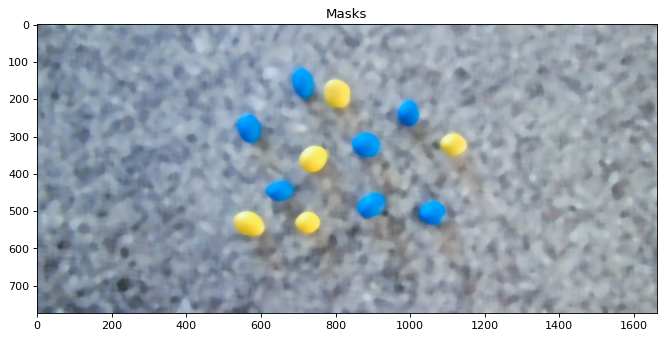

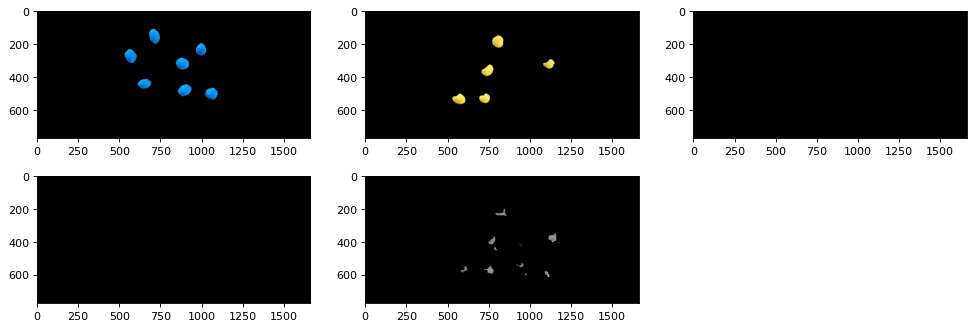

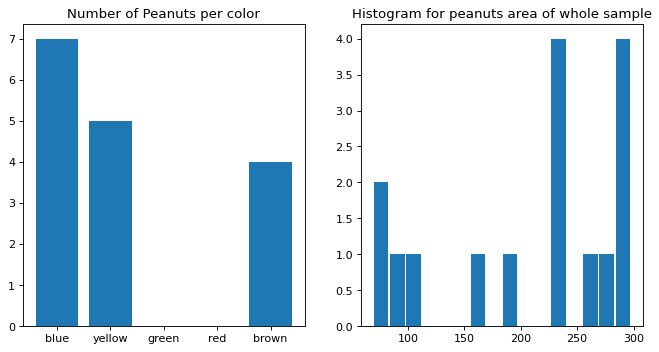

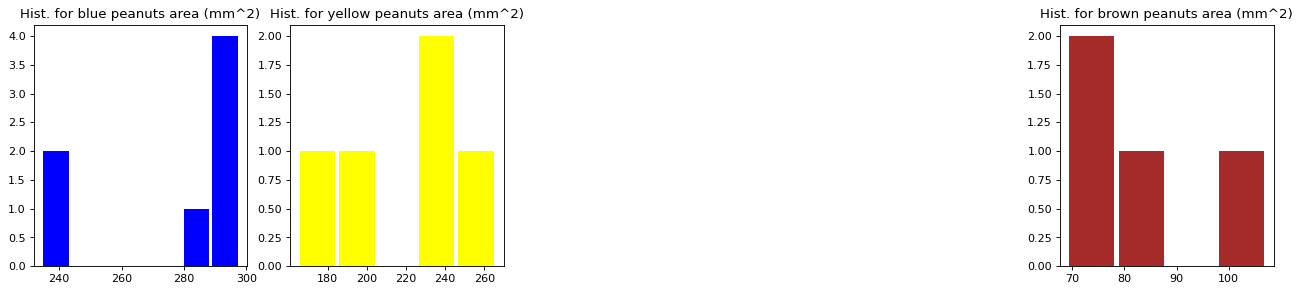


Looking for blue peanuts in the image 2
   Peanuts found!
   Areas in px: [3743.5, 3969.0, 3239.0, 4050.0, 4042.5, 3228.5, 3957.0]
   Areas in mm [256.99 272.47 222.35 278.03 277.51 221.63 271.64]
Looking for yellow peanuts in the image 2
   Peanuts found!
   Areas in px: [3031.0, 1976.0, 3010.5, 1920.0, 3423.5]
   Areas in mm [208.07 135.65 206.67 131.81 235.02]
Looking for green peanuts in the image 2
   Peanuts found!
   Areas in px: [3073.5, 2970.5, 1762.0]
   Areas in mm [210.99 203.92 120.96]
Looking for red peanuts in the image 2
   Color red is missing!
Looking for brown peanuts in the image 2
   Peanuts found!
   Areas in px: [1322.0]
   Areas in mm [90.75]


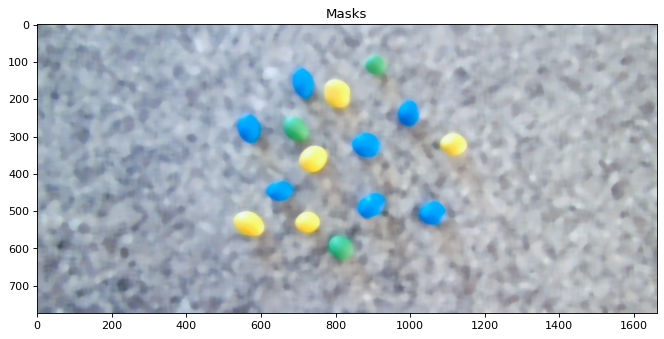

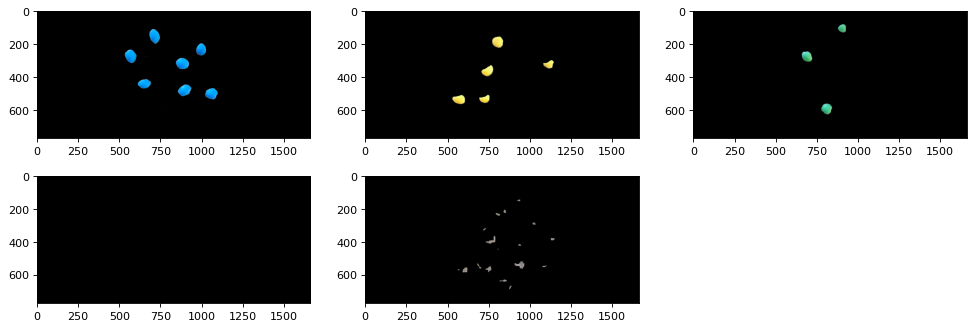

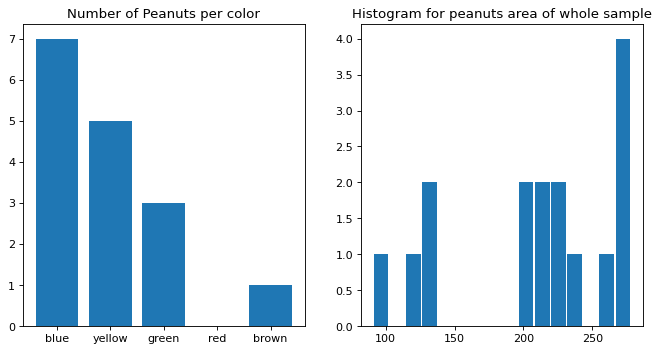

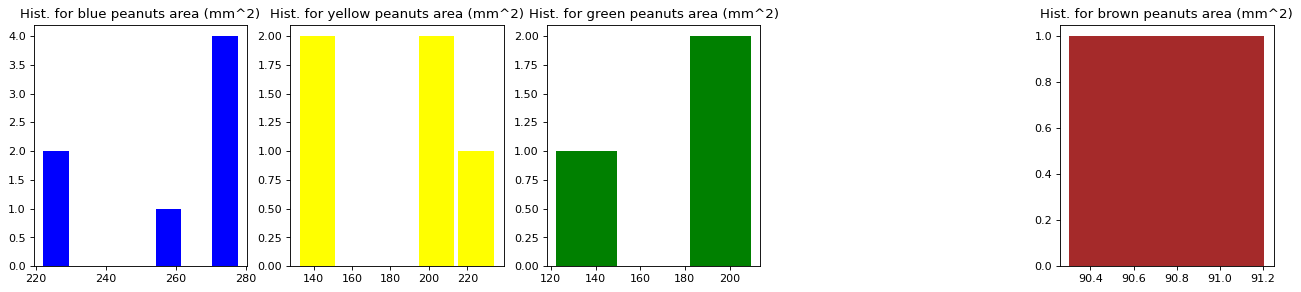


Looking for blue peanuts in the image 3
   Peanuts found!
   Areas in px: [3663.0, 4118.0, 3263.0, 4090.5, 4068.0, 3213.5, 3982.0]
   Areas in mm [251.46 282.69 224.   280.81 279.26 220.6  273.36]
Looking for yellow peanuts in the image 3
   Peanuts found!
   Areas in px: [3038.0, 3641.5, 3836.5, 2926.0, 4102.0]
   Areas in mm [208.55 249.98 263.37 200.87 281.6 ]
Looking for green peanuts in the image 3
   Peanuts found!
   Areas in px: [3164.5, 3024.0, 1821.0]
   Areas in mm [217.24 207.59 125.01]
Looking for red peanuts in the image 3
   Peanuts found!
   Areas in px: [3682.5, 2960.5, 2489.5, 2884.0, 2148.0]
   Areas in mm [252.8  203.23 170.9  197.98 147.46]
Looking for brown peanuts in the image 3
   Peanuts found!
   Areas in px: [4738.5, 4570.5, 2056.0, 2542.5, 10838.5, 1468.0, 1804.5, 1174.5, 6665.5, 4339.5, 17242.0, 1031.0]
   Areas in mm [ 325.29  313.76  141.14  174.54  744.05  100.78  123.88   80.63  457.58
  297.9  1183.64   70.78]


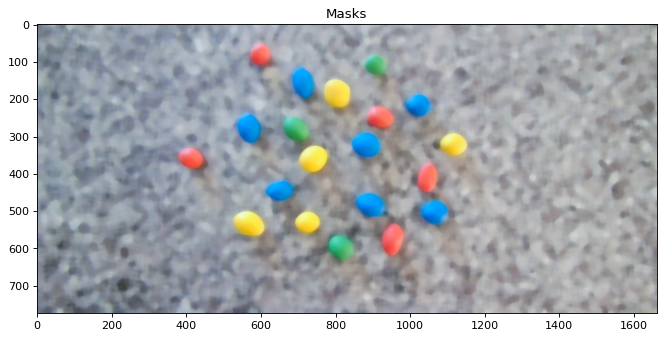

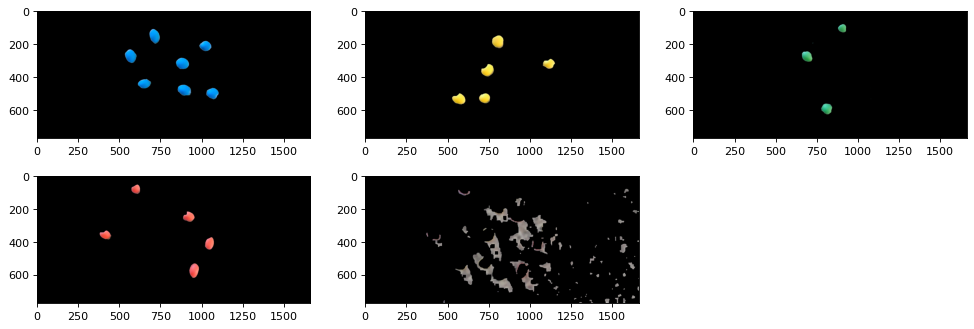

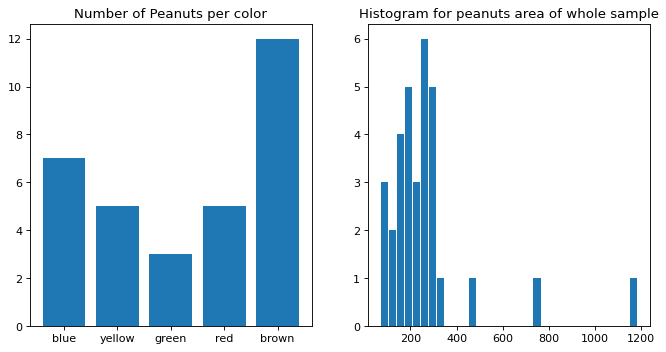

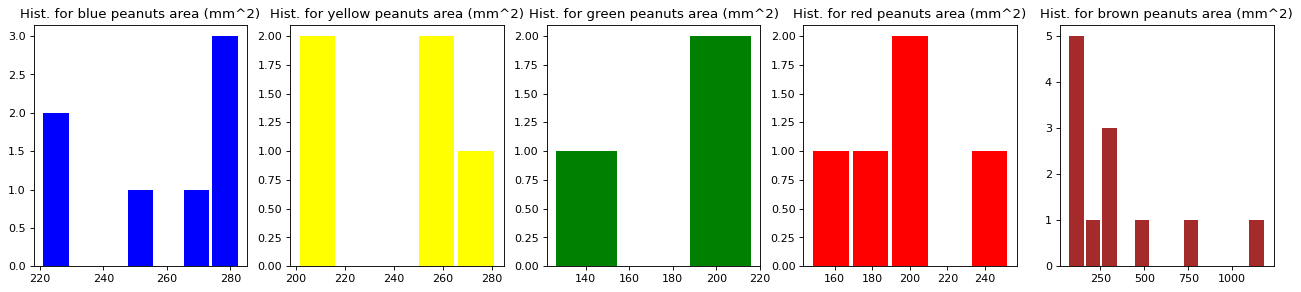


Looking for blue peanuts in the image 4
   Peanuts found!
   Areas in px: [3830.5, 4278.5, 3463.5, 4435.5, 4483.5, 3369.5, 4199.5]
   Areas in mm [262.96 293.71 237.76 304.49 307.79 231.31 288.29]
Looking for yellow peanuts in the image 4
   Peanuts found!
   Areas in px: [1700.5, 2962.5, 2360.5, 1576.0, 2956.0]
   Areas in mm [116.74 203.37 162.04 108.19 202.93]
Looking for green peanuts in the image 4
   Peanuts found!
   Areas in px: [3306.0, 3232.5, 1921.0]
   Areas in mm [226.95 221.91 131.87]
Looking for red peanuts in the image 4
   Peanuts found!
   Areas in px: [3202.5, 2624.5, 2014.0, 2162.5, 1696.5]
   Areas in mm [219.85 180.17 138.26 148.45 116.46]
Looking for brown peanuts in the image 4
   Peanuts found!
   Areas in px: [2627.0, 3183.0, 3077.0, 2115.5, 2180.5]
   Areas in mm [180.34 218.51 211.23 145.23 149.69]


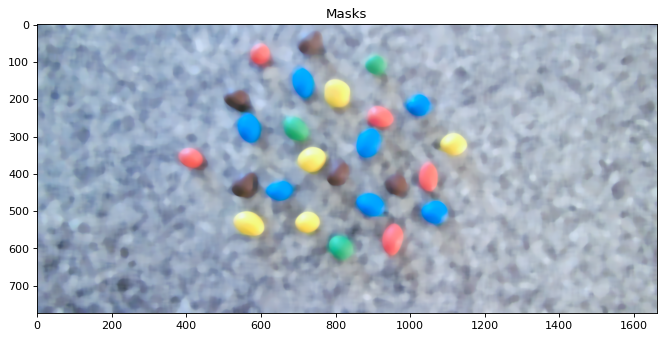

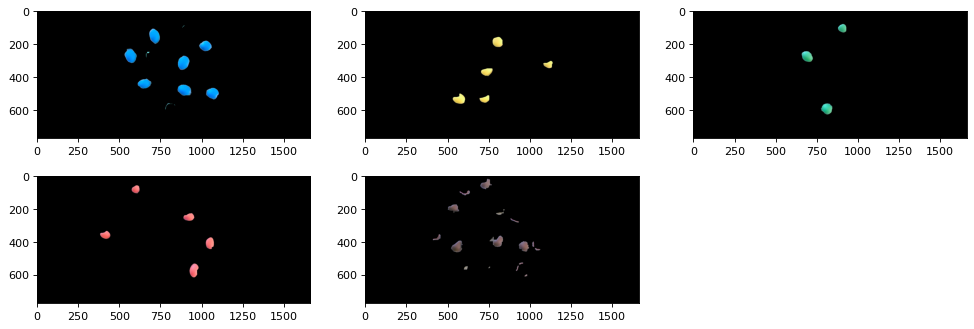

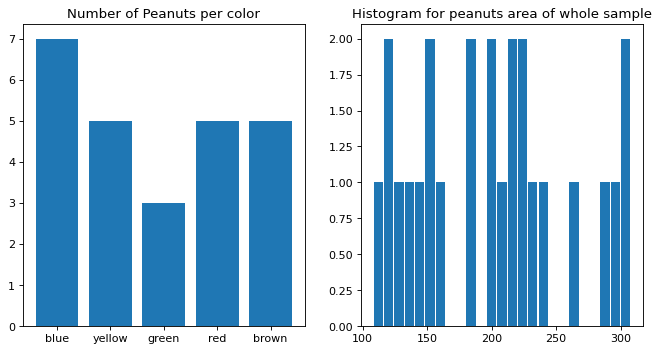

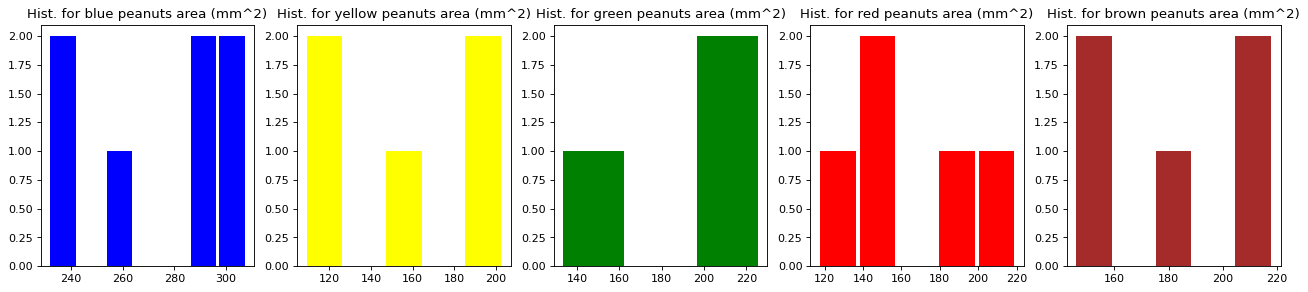


Looking for blue peanuts in the image 5
   Peanuts found!
   Areas in px: [8482.5, 4154.0, 12619.0]
   Areas in mm [582.31 285.17 866.28]
Looking for yellow peanuts in the image 5
   Peanuts found!
   Areas in px: [3199.5, 3955.5, 3936.0, 8453.0]
   Areas in mm [219.64 271.54 270.2  580.29]
Looking for green peanuts in the image 5
   Peanuts found!
   Areas in px: [5661.5, 3457.5]
   Areas in mm [388.65 237.35]
Looking for red peanuts in the image 5
   Peanuts found!
   Areas in px: [4022.0, 2999.0, 2389.5, 2092.0]
   Areas in mm [276.1  205.88 164.04 143.61]
Looking for brown peanuts in the image 5
   Peanuts found!
   Areas in px: [21043.5, 1199.5, 1203.0, 14923.0, 4843.5]
   Areas in mm [1444.61   82.34   82.58 1024.44  332.5 ]


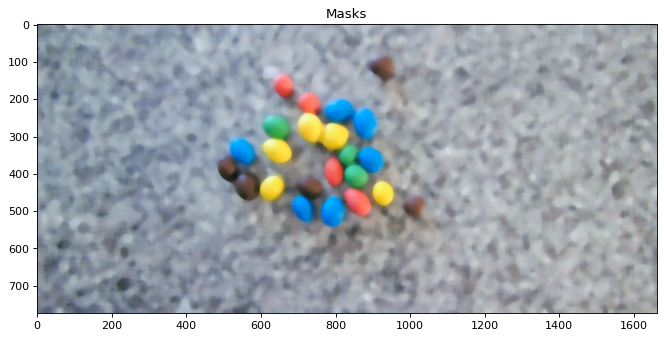

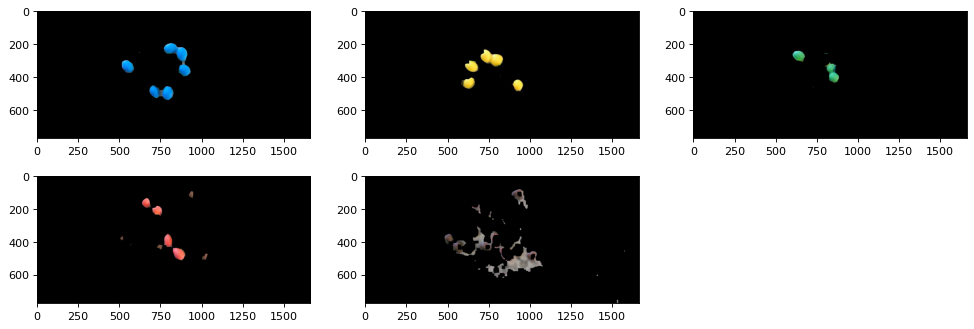

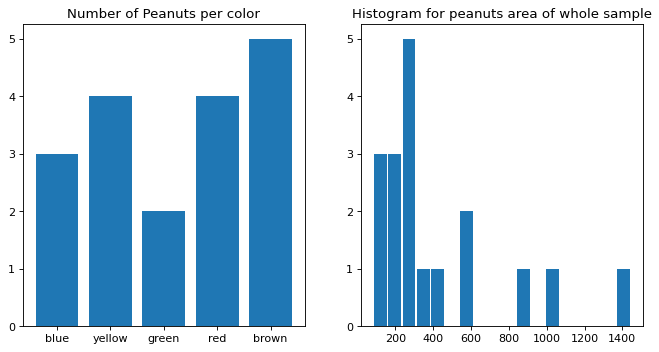

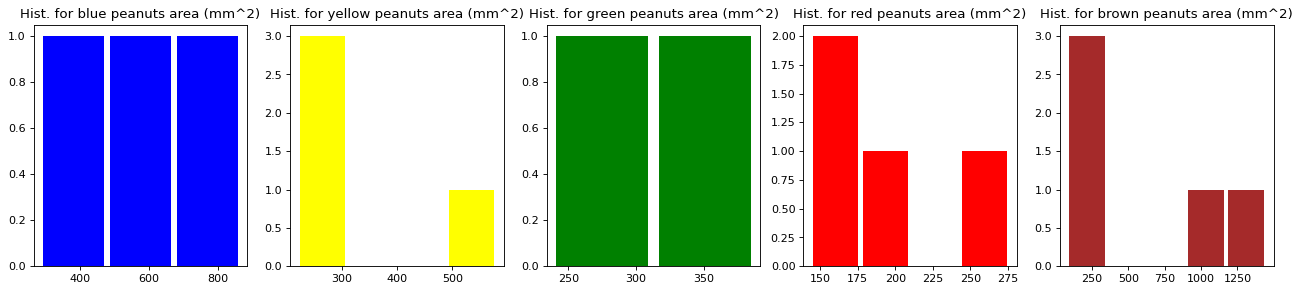

In [119]:
colors =  ['blue','yellow','green','red','brown']



lower = np.array([[90,120,20],[20,100,15],[35,100,20],[160,100,20],[0,100,20]])
upper = np.array([[125,255,255],[45,255,255],[92,255,255],[179,255,255],[10,255,255]])
lower_brown = np.array([[130,37,82],[8,60,70],[5,10,40]])
upper_brown = np.array([[180,70,150],[20,100,90],[20,70,160]])

areas = []
areas_in_px = []
areas_in_mm = []

ratio_mm_px = 1 / ratio_px_mm


for i in range(1,6):
  ## Load the image
  title = "./GreyBackground/calib_img " + str(i) +".png" 
  img_mm = cv.imread(title)
  #cv2_imshow(img_mm)

  h, w = img_mm.shape[:2]
  newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
  # undistort
  dst = cv.undistort(img_mm, mtx, dist, None, newcameramtx)
  # crop the image
  x, y, w, h = roi
  dst = dst[y:y+h, x:x+w]
  dst = cv.medianBlur(src=dst, ksize=21)

  "  ************ RGB Color Space ************* "
  sum_area = np.array([0,0,0,0,0])
  sum_peanuts = np.array([0,0,0,0,0])

  masks_img = []
  masks_img.append(dst)

  areas = []

  for idx,color in enumerate(colors):

    areas_in_px = []
    areas_in_mm = []

    print("Looking for " + color + " peanuts in the image " + str(i))
    frame_HSV = cv.cvtColor(dst, cv.COLOR_BGR2HSV)
    "  ************ Segmentation ************* "
    mask = cv.inRange(frame_HSV, lower[idx], upper[idx])

    if color == 'red':
      mask2 = cv.inRange(frame_HSV, lower[idx+1], upper[idx+1])
      mask = mask + mask2

    if color == 'brown':
      mask = cv.inRange(frame_HSV, lower_brown[0], upper_brown[0])
      mask2 = cv.inRange(frame_HSV, lower_brown[1], upper_brown[1])
      mask3 = cv.inRange(frame_HSV, lower_brown[2], upper_brown[2])
      mask = mask + mask2 + mask3

    "  ************ Close mask **************  "
    if color == 'brown':
      kernel = np.ones((11, 11), 'uint8')
      mask = cv.dilate(mask, kernel, iterations=2)
      kernel = np.ones((17, 17), 'uint8')
      mask = cv.erode(mask, kernel, iterations=1)
    else:
      kernel = np.ones((11, 11), 'uint8')
      mask = cv.dilate(mask, kernel, iterations=2)
      mask = cv.erode(mask, kernel, iterations=2)

    result = cv.bitwise_and(frame_HSV, frame_HSV, mask=mask)
    result = cv.cvtColor(result, cv.COLOR_HSV2BGR)

    masks_img.append(result)

    contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
    # Consider only contours with area higher than 1000
    for c in range(len(contours)):
      if (cv.contourArea(contours[c]) < 1000):
        continue
      sum_area[idx] = sum_area[idx] + cv.contourArea(contours[c])
      sum_peanuts[idx] = sum_peanuts[idx] + 1
      areas.append(cv.contourArea(contours[c]))
      areas_in_px.append(cv.contourArea(contours[c]))
      areas_in_mm.append(cv.contourArea(contours[c])*(ratio_mm_px**2) )
    
    if sum_peanuts[idx] == 0:
      print("   Color " + color + " is missing!")
    else:
      print("   Peanuts found!")
      print("   Areas in px:", areas_in_px)
      print("   Areas in mm", np.round(areas_in_mm,2))

  sum_area_mm = (ratio_mm_px ** 2) * sum_area

  for i in range(len(masks_img)):
    masks_img[i] = cv.cvtColor(masks_img[i],cv.COLOR_BGR2RGB)

  plt.figure(figsize=(10, 8), dpi=80)
  plt.title("Masks")
  plt.imshow(masks_img[0])
  plt.show()

  plt.figure(figsize=(15, 5), dpi=80)
  plt.subplot(2,3,1)
  plt.imshow(masks_img[1])
  plt.subplot(2,3,2)
  plt.imshow(masks_img[2])
  plt.subplot(2,3,3)
  plt.imshow(masks_img[3])
  plt.subplot(2,3,4)
  plt.imshow(masks_img[4])
  plt.subplot(2,3,5)
  plt.imshow(masks_img[5])
  plt.show()

  plt.figure(figsize=(10, 5), dpi=80)
  plt.subplot(1,2,1)
  plt.title('Number of Peanuts per color')
  plt.bar(colors,sum_peanuts)
  plt.subplot(1,2,2)
  plt.title('Histogram for peanuts area of whole sample')
  areas_mm = np.array(areas) * (ratio_mm_px**2) 
  plt.hist(areas_mm,bins=len(areas),rwidth=0.9)
  plt.show()

  plt.figure(figsize=(20, 4), dpi=80)
  
  if sum_peanuts[0]>0:
    plt.subplot(1,5,1)
    plt.title('Hist. for '+ colors[0]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[0:sum_peanuts[0]],bins=sum_peanuts[0],rwidth=0.9, color=colors[0])
  if sum_peanuts[1]>0:
    plt.subplot(1,5,2)
    plt.title('Hist. for '+ colors[1]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[sum_peanuts[0]:sum_peanuts[0]+sum_peanuts[1]],bins=sum_peanuts[1],rwidth=0.9, color=colors[1])
  if sum_peanuts[2]>0:
    plt.subplot(1,5,3)
    plt.title('Hist. for '+ colors[2]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[sum_peanuts[0]+sum_peanuts[1]:sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]],bins=sum_peanuts[2],rwidth=0.9, color=colors[2])
  if sum_peanuts[3]>0:
    plt.subplot(1,5,4)
    plt.title('Hist. for '+ colors[3]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]:sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]+sum_peanuts[3]],bins=sum_peanuts[3],rwidth=0.9, color=colors[3])
  if sum_peanuts[4]>0:
    plt.subplot(1,5,5)
    plt.title('Hist. for '+ colors[4]+ ' peanuts area (mm^2)')
    plt.hist(areas_mm[sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]+sum_peanuts[3]:sum_peanuts[0]+sum_peanuts[1]+sum_peanuts[2]+sum_peanuts[3]+sum_peanuts[4]],bins=sum_peanuts[4],rwidth=0.9, color=colors[4])
  plt.show()

  print("")
